In [51]:
# import all libraries
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression

In [52]:
#Create a wrangle function for the dataset
def wrangle(filepath):
    df = pd.read_csv(filepath).set_index("building_id")

    #Subset to houses in district 24,because I am interested in the district with the highest number of houses
    mask_district = df["district_id"] == 24
    df = df[mask_district]

    #Remove leaky columns
    drop_col = [col for col in df.columns if "post" in col]

    # Create a binary classification of the damage grade: 1-3 = 0 and 4 - 5 = 1
    df["damage_grade"] = (df["damage_grade"].str[-1].astype(int) > 3).astype(int)

    #Remove low and high cardinal columns
    drop_col.append("district_id")

    #Drop highly correlated feature
    drop_col.append("count_floors_pre_eq")
    
    #Drop columns
    df.drop(columns = drop_col, inplace = True)

    return df

df = wrangle("NepalEarhquakeDamage2015.csv")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,damage_grade
building_id,,,,,,,,,,,
240101000011,40,324,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0
240101000021,30,382,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,1
240101000031,13,405,10,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,1
240101000041,25,328,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Not attached,Rectangular,1
240101000051,15,405,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1


In [53]:
# Inspect dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98019 entries, 240101000011 to 249009000991
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            98019 non-null  int64 
 1   plinth_area_sq_ft       98019 non-null  int64 
 2   height_ft_pre_eq        98019 non-null  int64 
 3   land_surface_condition  98019 non-null  object
 4   foundation_type         98019 non-null  object
 5   roof_type               98019 non-null  object
 6   ground_floor_type       98019 non-null  object
 7   other_floor_type        98019 non-null  object
 8   position                98019 non-null  object
 9   plan_configuration      98019 non-null  object
 10  damage_grade            98019 non-null  int32 
dtypes: int32(1), int64(3), object(7)
memory usage: 8.6+ MB


In [54]:
# Check highly correlated column
corr = df.select_dtypes("number").drop(columns= ["damage_grade"]).corr()
corr

,age_building,plinth_area_sq_ft,height_ft_pre_eq
age_building,1.000000,-0.042042,0.026760
plinth_area_sq_ft,-0.042042,1.000000,0.308231
height_ft_pre_eq,0.026760,0.308231,1.000000


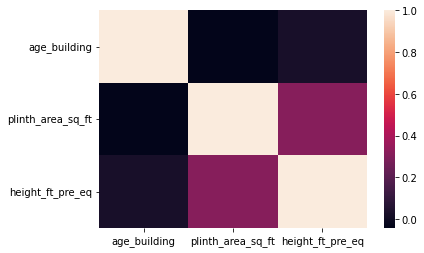

In [55]:
# Visualize correlation
sns.heatmap(corr);

In [56]:
# Calculate the majority and the minority class proportions
# 1-3= minority class (0)
# 4 and 5 = majority class (1)
majority_class, minority_class = df["damage_grade"].value_counts(normalize =True)

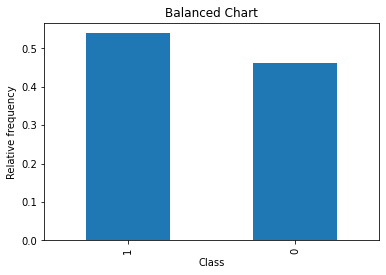

In [57]:
df["damage_grade"].value_counts(normalize =True).plot(
    kind = "bar"
)
plt.title("Balanced Chart")
plt.xlabel("Class")
plt.ylabel("Relative frequency");

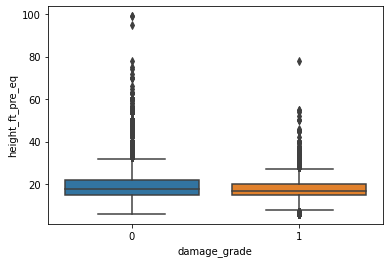

In [58]:
sns.boxplot(x = "damage_grade", y = "height_ft_pre_eq", data = df);

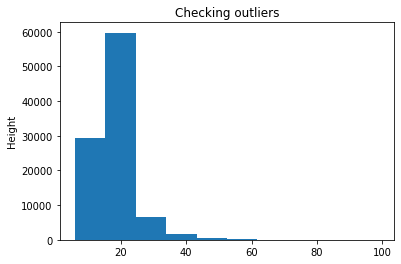

In [59]:
#Check outliers in the '"height_ft_pre_eq"'column using a histogram
df["height_ft_pre_eq"].plot(kind = "hist")
plt.title("Checking outliers")
plt.ylabel("Height");

In [60]:
# Create a pivot table to inspect the foundation type
pivot_table = pd.pivot_table(
    df,
    values = "damage_grade",
    index = "foundation_type",
    aggfunc= np.mean,
).sort_values("damage_grade", ascending = False)
pivot_table

,damage_grade
foundation_type,
Mud mortar-Stone/Brick,0.600677
Other,0.314741
Cement-Stone/Brick,0.272224
Bamboo/Timber,0.267281
RC,0.010949


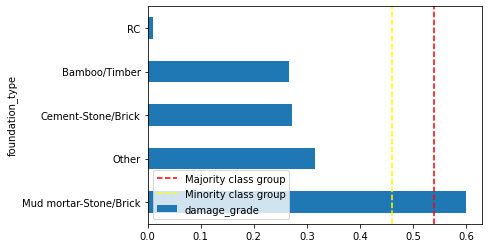

In [61]:
#Visualize the data on the pivot table
pivot_table.plot(kind = "barh")
plt.axvline(
    majority_class, linestyle = "--", color = "red", label = "Majority class group"
)  
plt.axvline(
    minority_class, linestyle = "--", color = "yellow", label = "Minority class group"
)  
plt.legend(loc = "lower left");

In [62]:
# Check low and high cardinality features
df.select_dtypes("object").nunique()

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
dtype: int64

In [63]:
# Create a vertical split
target = "damage_grade"
X = df.drop(columns=target)
y = df[target]


In [64]:
# Randomize train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 30
)

In [65]:
X_train.shape

(78415, 10)

In [66]:
y_train.shape

(78415,)

In [67]:
acc_score = y_train.value_counts(normalize = True).max().round(2)
print("Baseline Accuracy score:", acc_score)

Baseline Accuracy score: 0.54


In [68]:
# Create a pipeline for the model
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    LogisticRegression(max_iter=1000)
)
model

Pipeline(steps=[('onehotencoder', OneHotEncoder(use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [69]:
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [70]:
# Generate predictions
y_pred = model.predict_proba(X_train)[:,-1]
y_pred

array([0.61131534, 0.02011171, 0.60079297, ..., 0.56311187, 0.15736552,
       0.57264314])

In [71]:
# Calculate the test accuracy score
test_acc = model.score(X_test,y_test)
print("Test accuracy score:",test_acc.round(2))

Test accuracy score: 0.65


In [72]:
# Calculate feature importances
feature = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps["logisticregression"].coef_[0]

In [73]:
# Calculate odd's ratio
odd_ratio = pd.Series(np.exp(importances), index = feature).sort_values()
odd_ratio[:5]

roof_type_RCC/RB/RBC               0.445026
ground_floor_type_RC               0.455472
foundation_type_RC                 0.461280
foundation_type_Bamboo/Timber      0.597500
other_floor_type_Not applicable    0.684798
dtype: float64

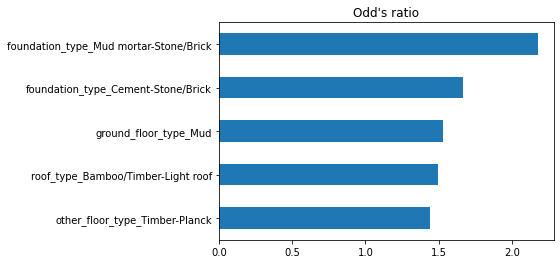

In [74]:
# Plot highest odd's ratios
odd_ratio.tail(5).plot(kind = "barh")
plt.title("Odd's ratio");

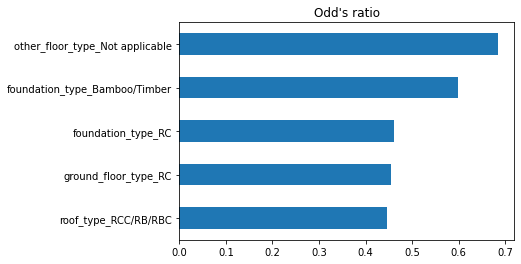

In [75]:
# Plot least odd's ratios
odd_ratio.head(5).plot(kind = "barh")
plt.title("Odd's ratio");